In [16]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"Project Root added: '{project_root}'")

Project Root added: 'd:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\AI\deepfake-detection\deep_fake_detection'


In [17]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
from src.preprocessing import get_transforms

In [18]:
def flip_label(y):
    return 1 - y

In [19]:
def get_dataloaders(root_dir, model_name, batch_size=32):
    """
    Args:
        root_dir: Should point to 'data/images' containing 'train' and 'val' folders.
    """
    # Define path
    train_dir = os.path.join(root_dir, 'train')
    valid_dir = os.path.join(root_dir, 'val')
    
    # Transforms
    transform = get_transforms(model_name)
    
    # Create Dataset with ImageFolder
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform, target_transform=flip_label)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform, target_transform=flip_label)
    
    print(f"Classes found: {train_dataset.class_to_idx}")
    print("APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.")
    
    # Loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True)
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True)
    
    return train_loader, valid_loader

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.simpleCNN import SimpleCNN
from src.utils import set_seed, train_one_epoch, evaluate, save_checkpoint, save_experiment_json

## **Configurations**

In [21]:
DATA_ROOT = '../data/images'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [22]:
print(f"Device using: {DEVICE}")

Device using: cuda


In [23]:
MODEL_NAME = 'simpleCNN'
TASK_NAME = 'deepfake_detection'

In [24]:
set_seed(42)

## **Preparation**

In [25]:
train_loader, valid_loader = get_dataloaders(DATA_ROOT, MODEL_NAME, BATCH_SIZE)
print(f"- Train batches: {len(train_loader)}\n- Valid batches: {len(valid_loader)}")

Classes found: {'fake': 0, 'real': 1}
APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.
- Train batches: 750
- Valid batches: 125


## **Model Setup**

In [26]:
model = SimpleCNN(num_classes=2).to(DEVICE)

In [27]:
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=16, bias=True)
  (leakly_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8)

In [29]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "EPOCHS": EPOCHS,
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": ""
}

best_acc = 0.0

## **Training**

In [30]:
for epoch in range(EPOCHS):
    # Train
    train_acc, train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"../results/best_{MODEL_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.22it/s]


[1/30] train_acc: 0.5621 - train_loss: 0.6859 - valid_acc: 0.6208 - valid_loss: 0.6620
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 1 - acc: 0.6208



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.45it/s]


[2/30] train_acc: 0.6026 - train_loss: 0.6603 - valid_acc: 0.6250 - valid_loss: 0.6367
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 2 - acc: 0.6250



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.21it/s]


[3/30] train_acc: 0.6234 - train_loss: 0.6441 - valid_acc: 0.6265 - valid_loss: 0.6368
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 3 - acc: 0.6265



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


[4/30] train_acc: 0.6384 - train_loss: 0.6309 - valid_acc: 0.6502 - valid_loss: 0.6314
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 4 - acc: 0.6502



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.48it/s]


[5/30] train_acc: 0.6481 - train_loss: 0.6194 - valid_acc: 0.6462 - valid_loss: 0.6486
	- [current best] epoch: 4 - acc: 0.6502



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.50it/s]


[6/30] train_acc: 0.6631 - train_loss: 0.6027 - valid_acc: 0.6573 - valid_loss: 0.6305
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 6 - acc: 0.6573



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.50it/s]


[7/30] train_acc: 0.6699 - train_loss: 0.5887 - valid_acc: 0.6677 - valid_loss: 0.6031
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 7 - acc: 0.6677



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.29it/s]


[8/30] train_acc: 0.6868 - train_loss: 0.5702 - valid_acc: 0.6697 - valid_loss: 0.6194
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 8 - acc: 0.6697



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.18it/s]


[9/30] train_acc: 0.6998 - train_loss: 0.5546 - valid_acc: 0.6747 - valid_loss: 0.6115
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 9 - acc: 0.6747



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.02it/s]


[10/30] train_acc: 0.7023 - train_loss: 0.5499 - valid_acc: 0.6905 - valid_loss: 0.6030
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 10 - acc: 0.6905



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.11it/s]


[11/30] train_acc: 0.7253 - train_loss: 0.5198 - valid_acc: 0.6817 - valid_loss: 0.5983
	- [current best] epoch: 10 - acc: 0.6905



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.10it/s]


[12/30] train_acc: 0.7394 - train_loss: 0.4989 - valid_acc: 0.7047 - valid_loss: 0.6071
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 12 - acc: 0.7047



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.33it/s]


[13/30] train_acc: 0.7514 - train_loss: 0.4820 - valid_acc: 0.6955 - valid_loss: 0.6359
	- [current best] epoch: 12 - acc: 0.7047



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.26it/s]


[14/30] train_acc: 0.7652 - train_loss: 0.4642 - valid_acc: 0.7050 - valid_loss: 0.6651
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 14 - acc: 0.7050



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.77it/s]


[15/30] train_acc: 0.7766 - train_loss: 0.4472 - valid_acc: 0.7053 - valid_loss: 0.6572
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 15 - acc: 0.7053



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.30it/s]


[16/30] train_acc: 0.7857 - train_loss: 0.4290 - valid_acc: 0.7055 - valid_loss: 0.6583
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 16 - acc: 0.7055



Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.82it/s]


[17/30] train_acc: 0.7963 - train_loss: 0.4167 - valid_acc: 0.7117 - valid_loss: 0.6660
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 17 - acc: 0.7117



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.16it/s]


[18/30] train_acc: 0.8025 - train_loss: 0.4040 - valid_acc: 0.7037 - valid_loss: 0.6847
	- [current best] epoch: 17 - acc: 0.7117



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.25it/s]


[19/30] train_acc: 0.8115 - train_loss: 0.3899 - valid_acc: 0.7035 - valid_loss: 0.7262
	- [current best] epoch: 17 - acc: 0.7117



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


[20/30] train_acc: 0.8209 - train_loss: 0.3766 - valid_acc: 0.7040 - valid_loss: 0.8176
	- [current best] epoch: 17 - acc: 0.7117



Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.88it/s]


[21/30] train_acc: 0.8221 - train_loss: 0.3685 - valid_acc: 0.7107 - valid_loss: 0.7307
	- [current best] epoch: 17 - acc: 0.7117



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.29it/s]


[22/30] train_acc: 0.8305 - train_loss: 0.3527 - valid_acc: 0.7015 - valid_loss: 0.7615
	- [current best] epoch: 17 - acc: 0.7117



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.33it/s]


[23/30] train_acc: 0.8380 - train_loss: 0.3380 - valid_acc: 0.7147 - valid_loss: 0.7073
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 23 - acc: 0.7147



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.16it/s]


[24/30] train_acc: 0.8425 - train_loss: 0.3342 - valid_acc: 0.6970 - valid_loss: 0.8726
	- [current best] epoch: 23 - acc: 0.7147



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.16it/s]


[25/30] train_acc: 0.8509 - train_loss: 0.3188 - valid_acc: 0.6940 - valid_loss: 0.9418
	- [current best] epoch: 23 - acc: 0.7147



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.20it/s]


[26/30] train_acc: 0.8466 - train_loss: 0.3235 - valid_acc: 0.7035 - valid_loss: 0.9128
	- [current best] epoch: 23 - acc: 0.7147



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.90it/s]


[27/30] train_acc: 0.8567 - train_loss: 0.3065 - valid_acc: 0.7123 - valid_loss: 0.8760
	- [current best] epoch: 23 - acc: 0.7147



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.77it/s]


[28/30] train_acc: 0.7952 - train_loss: 0.4160 - valid_acc: 0.7083 - valid_loss: 0.9013
	- [current best] epoch: 23 - acc: 0.7147



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.33it/s]


[29/30] train_acc: 0.8625 - train_loss: 0.2942 - valid_acc: 0.7167 - valid_loss: 0.8866
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 29 - acc: 0.7167



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.51it/s]

[30/30] train_acc: 0.8696 - train_loss: 0.2822 - valid_acc: 0.7105 - valid_loss: 0.9308
	- [current best] epoch: 29 - acc: 0.7167



In [31]:
json_filename = f"../results/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history, json_filename)

History saved to ../results/simpleCNN_deepfake_detection.json


## **Performance Evaluation**

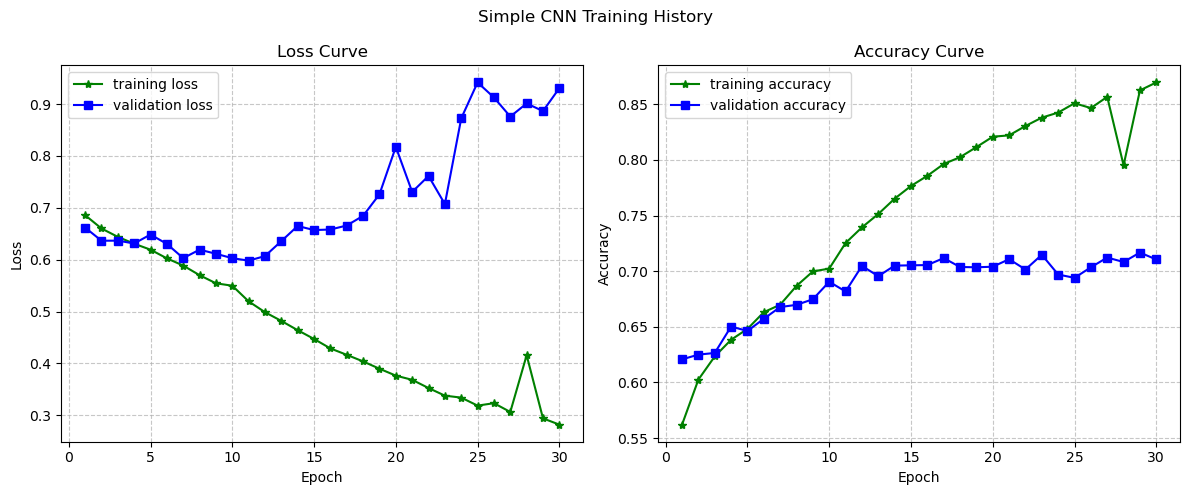

In [32]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Simple CNN Training History")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

img_save = f"../results/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def get_all_predictions(model, loader, device):
    """
    Runs inference on the entire loader and returns all true labels and predictions.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting Predictions"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

def plot_confusion_matrix_heatmap(model, loader, device, class_names=['Real', 'Fake']):
    """
    Generates and plots a confusion matrix heatmap.
    """
    y_true, y_pred = get_all_predictions(model, loader, device)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    img_save = f"../results/{MODEL_NAME}_{TASK_NAME}_cfm.png"
    plt.savefig(img_save)
    plt.show()

Getting Predictions: 100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


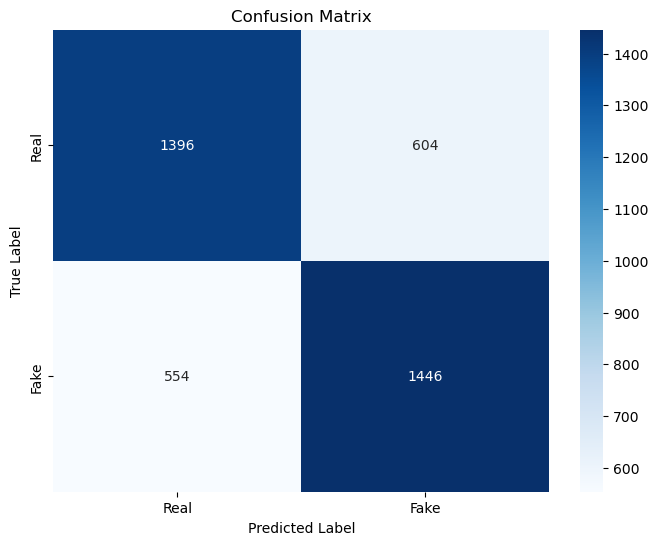

In [36]:
model.to(DEVICE)
plot_confusion_matrix_heatmap(model, valid_loader, DEVICE, class_names=['Real', 'Fake'])